# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = True

Fetch symbol data from internet; use cache if available.

In [5]:
ts = pf.fetch_timeseries(symbol)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,17.66
1928-01-03,17.76,17.76,17.76,17.76,0,17.76
1928-01-04,17.72,17.72,17.72,17.72,0,17.72
1928-01-05,17.55,17.55,17.55,17.55,0,17.55
1928-01-06,17.66,17.66,17.66,17.66,0,17.66


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [6]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,17.66
1928-01-03,17.76,17.76,17.76,17.76,0,17.76
1928-01-04,17.72,17.72,17.72,17.72,0,17.72
1928-01-05,17.55,17.55,17.55,17.55,0,17.55
1928-01-06,17.66,17.66,17.66,17.66,0,17.66


Add technical indicator: 50 day ma and 200 day ma

In [7]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.tail()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2019-12-17,3198.22,3191.03,3195.40,3192.52,3837540000,3192.52,3073.40,2948.42
2019-12-18,3198.48,3191.14,3195.21,3191.14,4014080000,3191.14,3079.36,2950.52
2019-12-19,3205.48,3192.32,3192.32,3205.37,3720450000,3205.37,3085.08,2952.81
2019-12-20,3225.65,3216.03,3223.33,3221.22,6454270000,3221.22,3090.74,2955.20
2019-12-23,3227.78,3222.30,3226.05,3224.01,1526831748,3224.01,3095.82,2957.40


Plot closing price along with moving averages

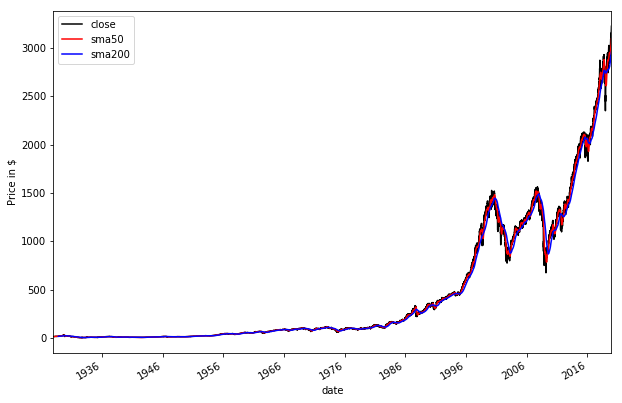

In [8]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [9]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [10]:
tlog.cash = capital
start_flag = True
end_flag = False

import time
t0 = time.time()

"""
# This is the slowest (2.42 s)
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

# This is still slow (2.53 s)
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']
    low = row['low']
    close = row['close']
    sma50 = row['sma50']
    sma200 = row['sma200']


# using .at[] is fast (832 ms)
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']
    low = ts.at[index, 'low']
    close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']
    sma200 = ts.at[index, 'sma200']

# using itertuples is fastest for looping (378 ms)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
    end_flag = True if (i == len(ts) - 1) else False
    trade_state = None
    shares = 0
        
    if pd.isnull(sma200) or date < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = date
        end = ts.index[-1]

    # buy
    if (tlog.num_open_trades() == 0
        and sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1] 
        and not end_flag):

        # enter buy in trade log
        shares = tlog.enter_trade(date, close)  
    # sell
    elif ((tlog.num_open_trades() > 0
           and sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1])
           or end_flag):

        # enter sell in trade log
        shares = tlog.exit_trade(date, close)

    if shares > 0:
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0:
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, -shares, symbol, close))

    # record daily balance
    dbal.append(date, high, low, close, tlog.shares, tlog.cash)    

t1 = time.time()
total = t1-t0
print(total)
        

1932-09-19 00:00:00 BUY  1362 ^GSPC @ 7.34
1933-03-27 00:00:00 SELL 1362 ^GSPC @ 6.09
1933-05-18 00:00:00 BUY  933 ^GSPC @ 8.89
1934-05-31 00:00:00 SELL 933 ^GSPC @ 9.61
1935-05-23 00:00:00 BUY  890 ^GSPC @ 10.07
1937-05-21 00:00:00 SELL 890 ^GSPC @ 16.27
1938-07-27 00:00:00 BUY  1182 ^GSPC @ 12.25
1939-03-31 00:00:00 SELL 1182 ^GSPC @ 10.98
1939-09-18 00:00:00 BUY  1041 ^GSPC @ 12.47
1940-03-20 00:00:00 SELL 1041 ^GSPC @ 12.14
1940-12-13 00:00:00 BUY  1182 ^GSPC @ 10.69
1941-02-21 00:00:00 SELL 1182 ^GSPC @ 9.76
1941-08-18 00:00:00 BUY  1139 ^GSPC @ 10.13
1941-11-18 00:00:00 SELL 1139 ^GSPC @ 9.26
1942-08-14 00:00:00 BUY  1229 ^GSPC @ 8.58
1943-12-01 00:00:00 SELL 1229 ^GSPC @ 11.13
1944-03-13 00:00:00 BUY  1118 ^GSPC @ 12.24
1946-08-28 00:00:00 SELL 1118 ^GSPC @ 16.73
1947-07-25 00:00:00 BUY  1163 ^GSPC @ 16.08
1948-01-22 00:00:00 SELL 1163 ^GSPC @ 14.42
1948-05-14 00:00:00 BUY  1023 ^GSPC @ 16.39
1948-12-01 00:00:00 SELL 1023 ^GSPC @ 15.01
1949-08-30 00:00:00 BUY  1010 ^GSPC @ 15.21

Retrieve raw log and trade log DataFrames

In [11]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [12]:
rlog.tail()

,date,price,shares,entry_exit
89,2016-01-11,1923.67,973,exit
90,2016-04-25,2087.79,897,entry
91,2018-12-07,2633.08,897,exit
92,2019-04-01,2867.19,823,entry
93,2019-12-23,3224.01,823,exit


In [13]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total
37,1999-11-11,1381.46,2000-10-30,1398.66,17.20,9855.64,573,791686.75
38,2003-05-14,939.28,2004-08-18,1095.17,155.89,132974.18,853,924660.93
39,2004-11-05,1166.17,2006-07-19,1259.81,93.64,75005.65,801,999666.58
40,2006-09-12,1313.00,2007-12-21,1484.46,171.46,131681.25,768,1131347.83
41,2009-06-23,895.10,2010-07-02,1022.58,127.48,162537.05,1275,1293884.89
42,2010-10-22,1183.08,2011-08-12,1178.81,-4.27,-4705.43,1102,1289179.46
43,2012-01-31,1312.41,2015-08-28,1988.87,676.46,669018.90,989,1958198.36
44,2015-12-21,2021.15,2016-01-11,1923.67,-97.48,-94848.02,973,1863350.34
45,2016-04-25,2087.79,2018-12-07,2633.08,545.29,489125.17,897,2352475.50
46,2019-04-01,2867.19,2019-12-23,3224.01,356.82,293662.92,823,2646138.42


In [14]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2019-12-17,2634913.22,2628995.90,2630222.16,823,2778.18,-
2019-12-18,2635127.21,2629086.31,2629086.31,823,2778.18,-
2019-12-19,2640888.21,2630057.60,2640797.79,823,2778.18,-
2019-12-20,2657488.05,2649570.90,2653842.22,823,2778.18,-
2019-12-23,2656138.42,2656138.42,2656138.42,0,2656138.42,X


Generate strategy stats - display all available stats

In [15]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                  1928-10-16
end                                                    2019-12-23
beginning_balance                                           10000
ending_balance                                         2656138.42
total_net_profit                                       2646138.42
gross_profit                                           2803035.31
gross_loss                                             -156896.89
profit_factor                                               17.87
return_on_initial_capital                                26461.38
annual_return_rate                                           6.31
trading_period                           91 years 2 months 7 days
pct_time_in_market                                          65.96
total_num_trades                                               47
trades_per_year                                              0.52
num_winning_trades                                             32
num_losing

Run Benchmark

In [16]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

1928-10-16 00:00:00 BUY  460 ^GSPC @ 21.72
2019-12-23 00:00:00 SELL 460 ^GSPC @ 3224.01


Retrieve benchmark logs

In [17]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [18]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                  1928-10-16
end                                                    2019-12-23
beginning_balance                                           10000
ending_balance                                         1483053.40
total_net_profit                                       1473053.40
gross_profit                                           1473053.40
gross_loss                                                   0.00
profit_factor                                                1000
return_on_initial_capital                                14730.53
annual_return_rate                                           5.64
trading_period                           91 years 2 months 7 days
pct_time_in_market                                         100.00
total_num_trades                                                1
trades_per_year                                              0.01
num_winning_trades                                              1
num_losing

Plot Equity Curves: Strategy vs Benchmark

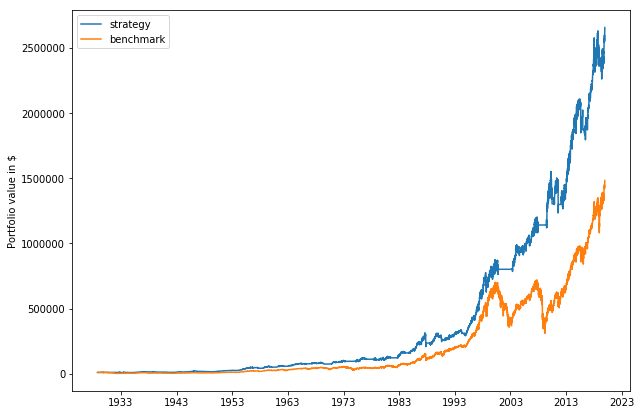

In [19]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

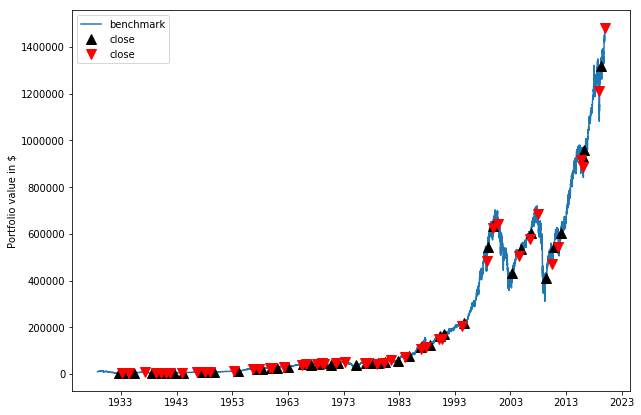

In [20]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

In [21]:
metrics = ('annual_return_rate',
           'ending_balance',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std',
           'pct_time_in_market',
           'total_num_trades',
           'pct_profitable_trades',
           'trades_per_year',
           'avg_points')

df = pf.summary2(stats, benchmark.stats, *metrics)
df

,strategy,benchmark
annual_return_rate,6.31,5.64
ending_balance,2656138.42,1483053.40
max_closed_out_drawdown,-36.86,-86.14
drawdown_annualized_return,-5.84,-15.28
drawdown_recovery,-4.68,-2.71
best_month,22.49,61.27
worst_month,-29.56,-42.17
sharpe_ratio,0.55,0.39
sortino_ratio,0.55,0.49
monthly_std,3.22,5.30
